### Import Libraries

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import network
import morphology
import os
import math
import torch.nn as nn
import torch.nn.init as init
import torchvision
import matplotlib.pyplot as plt

In [5]:
## define network

class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

class BetaVAE_B_256(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=1):
        super(BetaVAE_B_256, self).__init__()
        self.nc = nc
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32,  8,  8
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32,  4,  4
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32,  4,  4
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32,  4,  4
            nn.ReLU(True),
            View((-1, 32*4*4)),                  # B, 512
            nn.Linear(32*4*4, 256),              # B, 256
            nn.ReLU(True),
            nn.Linear(256, 256),                 # B, 256
            nn.ReLU(True),
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            nn.ReLU(True),
            nn.Linear(256, 256),                 # B, 256
            nn.ReLU(True),
            nn.Linear(256, 32*4*4),              # B, 512
            nn.ReLU(True),
            View((-1, 32, 4, 4)),                # B,  32,  4,  4
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1), # B,  nc, 64, 64
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar
    
    def sample(self,z):
        x_recon = self._decode(z)
        x_recon = torch.sigmoid(x_recon)
        return x_recon

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)
    
    

In [6]:
def save_img(img, output_path):
    result = Image.fromarray((img.data.cpu().numpy().transpose((1, 2, 0)) * 255).astype(np.uint8))
    result.save(output_path)

In [7]:
def param2stroke(param, H, W, meta_brushes):
    """
    Input a set of stroke parameters and output its corresponding foregrounds and alpha maps.
    Args:
        param: a tensor with shape n_strokes x n_param_per_stroke. Here, param_per_stroke is 8:
        x_center, y_center, width, height, theta, R, G, and B.
        H: output height.
        W: output width.
        meta_brushes: a tensor with shape 2 x 3 x meta_brush_height x meta_brush_width.
         The first slice on the batch dimension denotes vertical brush and the second one denotes horizontal brush.

    Returns:
        foregrounds: a tensor with shape n_strokes x 3 x H x W, containing color information.
        alphas: a tensor with shape n_strokes x 3 x H x W,
         containing binary information of whether a pixel is belonging to the stroke (alpha mat), for painting process.
    """
    # Firstly, resize the meta brushes to the required shape,
    # in order to decrease GPU memory especially when the required shape is small.
    meta_brushes_resize = F.interpolate(meta_brushes, (H, W))
    b = param.shape[0]
    # Extract shape parameters and color parameters.
    param_list = torch.split(param, 1, dim=1)
    x0, y0, w, h, theta = [item.squeeze(-1) for item in param_list[:5]]
    R, G, B = param_list[5:]
    # Pre-compute sin theta and cos theta
    sin_theta = torch.sin(torch.acos(torch.tensor(-1., device=param.device)) * theta)
    cos_theta = torch.cos(torch.acos(torch.tensor(-1., device=param.device)) * theta)
    # index means each stroke should use which meta stroke? Vertical meta stroke or horizontal meta stroke.
    # When h > w, vertical stroke should be used. When h <= w, horizontal stroke should be used.
    index = torch.full((b,), -1, device=param.device, dtype=torch.long)
    index[h > w] = 0
    index[h <= w] = 1
    brush = meta_brushes_resize[index.long()]

    # Calculate warp matrix according to the rules defined by pytorch, in order for warping.
    warp_00 = cos_theta / w
    warp_01 = sin_theta * H / (W * w)
    warp_02 = (1 - 2 * x0) * cos_theta / w + (1 - 2 * y0) * sin_theta * H / (W * w)
    warp_10 = -sin_theta * W / (H * h)
    warp_11 = cos_theta / h
    warp_12 = (1 - 2 * y0) * cos_theta / h - (1 - 2 * x0) * sin_theta * W / (H * h)
    warp_0 = torch.stack([warp_00, warp_01, warp_02], dim=1)
    warp_1 = torch.stack([warp_10, warp_11, warp_12], dim=1)
    warp = torch.stack([warp_0, warp_1], dim=1)
    # Conduct warping.
    grid = F.affine_grid(warp, [b, 3, H, W], align_corners=False)
    brush = F.grid_sample(brush, grid, align_corners=False)
    # alphas is the binary information suggesting whether a pixel is belonging to the stroke.
    alphas = (brush > 0).float()
    brush = brush.repeat(1, 3, 1, 1)
    alphas = alphas.repeat(1, 3, 1, 1)
    # Give color to foreground strokes.
    color_map = torch.cat([R, G, B], dim=1)
    color_map = color_map.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, H, W)
    foreground = brush * color_map
    # Dilation and erosion are used for foregrounds and alphas respectively to prevent artifacts on stroke borders.
    foreground = morphology.dilation(foreground)
    alphas = morphology.erosion(alphas)
    return foreground, alphas

In [8]:
def latent2stroke(self, param, H,W, model):
    # param: b, 10 (latent) + 3 (RGB)
    T = torchvision.transforms.Resize([H,W])
    b = param.shape[0]
#         print(param[:,:-3].shape)
#         with torch.no_grad():
    param_latent = (param[:,:5] / torch.norm(param[:,:5],dim=1).unsqueeze(1))*self.opt.sigma
    img = model.sample(param_latent) ### this outputs bx3xHxW image
    # print(param[:,:5])
    img = T(img)
    img = img.repeat(1,3,1,1)
    # print(img.shape)
    alphas = (img>0.1).float()
#         img[img<0.3] = 0
    img = alphas*img
    rgb = (1+param[:,5:8]).unsqueeze(2).unsqueeze(3)/2
    # print('rgb',rgb)
    # if alpha
#         print(img.device, rgb.device)
    # print(rgb)
    brush = img*rgb

    return brush, alphas

In [16]:
def read_img(img_path, img_type='RGB', h=None, w=None):
    img = Image.open(img_path).convert(img_type)
    if h is not None and w is not None:
        img = img.resize((w, h), resample=Image.NEAREST)
    img = np.array(img)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    img = img.transpose((2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float() / 255.
    return img


def pad(img, H, W):
    b, c, h, w = img.shape
    pad_h = (H - h) // 2
    pad_w = (W - w) // 2
    remainder_h = (H - h) % 2
    remainder_w = (W - w) % 2
    img = torch.cat([torch.zeros((b, c, pad_h, w), device=img.device), img,
                     torch.zeros((b, c, pad_h + remainder_h, w), device=img.device)], dim=-2)
    img = torch.cat([torch.zeros((b, c, H, pad_w), device=img.device), img,
                     torch.zeros((b, c, H, pad_w + remainder_w), device=img.device)], dim=-1)
    return img


def crop(img, h, w):
    H, W = img.shape[-2:]
    pad_h = (H - h) // 2
    pad_w = (W - w) // 2
    remainder_h = (H - h) % 2
    remainder_w = (W - w) % 2
    img = img[:, :, pad_h:H - pad_h - remainder_h, pad_w:W - pad_w - remainder_w]
    return img


In [9]:
input_path='input/chicago.jpg'
model_path='../train/checkpoints/painter_generative_GTstroke_8_background_24_GT_100_pix_10_iou_0.8/latest_net_g.pth'
output_dir='output/'
generative=True
need_animation=False  # whether need intermediate results for animation.
resize_h=None         # resize original input to this size. None means do not resize.
resize_w=None         # resize original input to this size. None means do not resize.
serial=False

In [12]:
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
input_name = os.path.basename(input_path)
output_path = os.path.join(output_dir, input_name)
frame_dir = None
if need_animation:
    if not serial:
        print('It must be under serial mode if animation results are required, so serial flag is set to True!')
        serial = True
    frame_dir = os.path.join(output_dir, input_name[:input_name.find('.')])
    if not os.path.exists(frame_dir):
        os.mkdir(frame_dir)
patch_size = 32
stroke_num = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_g = network.Painter(5, stroke_num, 256, 8, 3, 3).to(device)
net_g.load_state_dict(torch.load(model_path))
net_g.eval()
for param in net_g.parameters():
    param.requires_grad = False

if not generative:
    brush_large_vertical = read_img('brush/brush_large_vertical.png', 'L').to(device)
    brush_large_horizontal = read_img('brush/brush_large_horizontal.png', 'L').to(device)
    meta_brushes = torch.cat(
        [brush_large_vertical, brush_large_horizontal], dim=0)
else:
    model = BetaVAE_B_256(z_dim=5, nc=1)       
    state = torch.load(os.path.join('../train/strokes_aug_gamma100_z5_size256_iter_400000.pt'),map_location='cpu')        
    model.load_state_dict(state['model_states']['net'])
    for param in model.parameters():
        # print(param, param.requires_grad)
        param.requires_grad = False
        
    generative_model = model.to(device)

/home/yhpark/anaconda3/envs/generative/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  del sys.path[0]


In [17]:
original_img = read_img(input_path, 'RGB', resize_h, resize_w).to(device)  # 이미지 읽어옴
original_h, original_w = original_img.shape[-2:]  # 이미지 shape checking
K = max(math.ceil(math.log2(max(original_h, original_w) / patch_size)), 0) 
original_img_pad_size = patch_size * (2 ** K)  
original_img_pad = pad(original_img, original_img_pad_size, original_img_pad_size)
final_result = torch.zeros_like(original_img_pad).to(device)


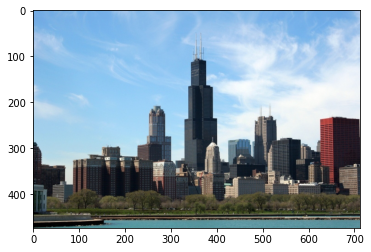

In [28]:
plt.imshow(original_img[0].detach().cpu().permute(1,2,0))

5


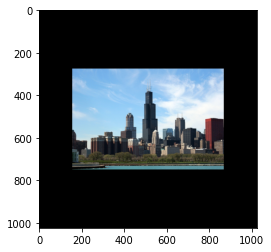

In [29]:
print(K)
plt.imshow(original_img_pad[0].detach().cpu().permute(1,2,0))

In [30]:
layer =0 

In [31]:
layer_size = patch_size * (2 ** layer)
img = F.interpolate(original_img_pad, (layer_size, layer_size)) # 1, 3, 32, 32
result = F.interpolate(final_result, (patch_size * (2 ** layer), patch_size * (2 ** layer)))
img_patch = F.unfold(img, (patch_size, patch_size), stride=(patch_size, patch_size)) # 1, 3072,1
result_patch = F.unfold(result, (patch_size, patch_size),
                        stride=(patch_size, patch_size))
# There are patch_num * patch_num patches in total
patch_num = (layer_size - patch_size) // patch_size + 1


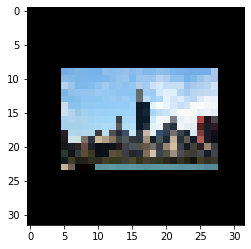

In [35]:
plt.imshow(img[0].detach().cpu().permute(1,2,0))

In [38]:
img.shape, img_patch.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3072, 1]))

In [39]:
# img_patch, result_patch: b, 3 * output_size * output_size, h * w
img_patch = img_patch.permute(0, 2, 1).contiguous().view(-1, 3, patch_size, patch_size).contiguous()
result_patch = result_patch.permute(0, 2, 1).contiguous().view(
    -1, 3, patch_size, patch_size).contiguous()
shape_param, stroke_decision = net_g(img_patch, result_patch)
stroke_decision = network.SignWithSigmoidGrad.apply(stroke_decision)


In [41]:
img_patch.shape

torch.Size([1, 3, 32, 32])

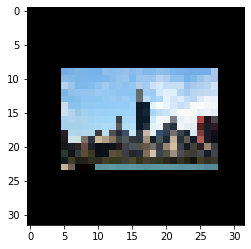

In [42]:
plt.imshow(img_patch[0].detach().cpu().permute(1,2,0))

In [ ]:
def param2img_serial(
        param, decision, generative_model, cur_canvas, frame_dir, has_border=False, original_h=None, original_w=None):
    """
    Input stroke parameters and decisions for each patch, meta brushes, current canvas, frame directory,
    and whether there is a border (if intermediate painting results are required).
    Output the painting results of adding the corresponding strokes on the current canvas.
    Args:
        param: a tensor with shape batch size x patch along height dimension x patch along width dimension
         x n_stroke_per_patch x n_param_per_stroke
        decision: a 01 tensor with shape batch size x patch along height dimension x patch along width dimension
         x n_stroke_per_patch
        meta_brushes: a tensor with shape 2 x 3 x meta_brush_height x meta_brush_width.
        The first slice on the batch dimension denotes vertical brush and the second one denotes horizontal brush.
        cur_canvas: a tensor with shape batch size x 3 x H x W,
         where H and W denote height and width of padded results of original images.
        frame_dir: directory to save intermediate painting results. None means intermediate results are not required.
        has_border: on the last painting layer, in order to make sure that the painting results do not miss
         any important detail, we choose to paint again on this layer but shift patch_size // 2 pixels when
         cutting patches. In this case, if intermediate results are required, we need to cut the shifted length
         on the border before saving, or there would be a black border.
        original_h: to indicate the original height for cropping when saving intermediate results.
        original_w: to indicate the original width for cropping when saving intermediate results.

    Returns:
        cur_canvas: a tensor with shape batch size x 3 x H x W, denoting painting results.
    """
    # param: b, h, w, stroke_per_patch, param_per_stroke
    # decision: b, h, w, stroke_per_patch
    b, h, w, s, p = param.shape
    H, W = cur_canvas.shape[-2:]
    is_odd_y = h % 2 == 1
    is_odd_x = w % 2 == 1
    patch_size_y = 2 * H // h
    patch_size_x = 2 * W // w
    even_idx_y = torch.arange(0, h, 2, device=cur_canvas.device)
    even_idx_x = torch.arange(0, w, 2, device=cur_canvas.device)
    odd_idx_y = torch.arange(1, h, 2, device=cur_canvas.device)
    odd_idx_x = torch.arange(1, w, 2, device=cur_canvas.device)
    even_y_even_x_coord_y, even_y_even_x_coord_x = torch.meshgrid([even_idx_y, even_idx_x])
    odd_y_odd_x_coord_y, odd_y_odd_x_coord_x = torch.meshgrid([odd_idx_y, odd_idx_x])
    even_y_odd_x_coord_y, even_y_odd_x_coord_x = torch.meshgrid([even_idx_y, odd_idx_x])
    odd_y_even_x_coord_y, odd_y_even_x_coord_x = torch.meshgrid([odd_idx_y, even_idx_x])
    cur_canvas = F.pad(cur_canvas, [patch_size_x // 4, patch_size_x // 4,
                                    patch_size_y // 4, patch_size_y // 4, 0, 0, 0, 0])

    def partial_render(this_canvas, patch_coord_y, patch_coord_x, stroke_id):
        canvas_patch = F.unfold(this_canvas, (patch_size_y, patch_size_x),
                                stride=(patch_size_y // 2, patch_size_x // 2))
        # canvas_patch: b, 3 * py * px, h * w
        canvas_patch = canvas_patch.view(b, 3, patch_size_y, patch_size_x, h, w).contiguous()
        canvas_patch = canvas_patch.permute(0, 4, 5, 1, 2, 3).contiguous()
        # canvas_patch: b, h, w, 3, py, px
        selected_canvas_patch = canvas_patch[:, patch_coord_y, patch_coord_x, :, :, :]
        selected_h, selected_w = selected_canvas_patch.shape[1:3]
        selected_param = param[:, patch_coord_y, patch_coord_x, stroke_id, :].view(-1, p).contiguous()
        selected_decision = decision[:, patch_coord_y, patch_coord_x, stroke_id].view(-1).contiguous()
        selected_foregrounds = torch.zeros(selected_param.shape[0], 3, patch_size_y, patch_size_x,
                                           device=this_canvas.device)
        selected_alphas = torch.zeros(selected_param.shape[0], 3, patch_size_y, patch_size_x, device=this_canvas.device)
        if selected_param[selected_decision, :].shape[0] > 0:
            selected_foregrounds[selected_decision, :, :, :], selected_alphas[selected_decision, :, :, :] = \
                param2stroke(selected_param[selected_decision, :], patch_size_y, patch_size_x, meta_brushes)
        selected_foregrounds = selected_foregrounds.view(
            b, selected_h, selected_w, 3, patch_size_y, patch_size_x).contiguous()
        selected_alphas = selected_alphas.view(b, selected_h, selected_w, 3, patch_size_y, patch_size_x).contiguous()
        selected_decision = selected_decision.view(b, selected_h, selected_w, 1, 1, 1).contiguous()
        selected_canvas_patch = selected_foregrounds * selected_alphas * selected_decision + selected_canvas_patch * (
                1 - selected_alphas * selected_decision)
        this_canvas = selected_canvas_patch.permute(0, 3, 1, 4, 2, 5).contiguous()
        # this_canvas: b, 3, selected_h, py, selected_w, px
        this_canvas = this_canvas.view(b, 3, selected_h * patch_size_y, selected_w * patch_size_x).contiguous()
        # this_canvas: b, 3, selected_h * py, selected_w * px
        return this_canvas

    global idx
    if has_border:
        factor = 2
    else:
        factor = 4
    if even_idx_y.shape[0] > 0 and even_idx_x.shape[0] > 0:
        for i in range(s):
            canvas = partial_render(cur_canvas, even_y_even_x_coord_y, even_y_even_x_coord_x, i)
            if not is_odd_y:
                canvas = torch.cat([canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
            if not is_odd_x:
                canvas = torch.cat([canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
            cur_canvas = canvas
            idx += 1
            if frame_dir is not None:
                frame = crop(cur_canvas[:, :, patch_size_y // factor:-patch_size_y // factor,
                             patch_size_x // factor:-patch_size_x // factor], original_h, original_w)
                save_img(frame[0], os.path.join(frame_dir, '%03d.jpg' % idx))

    if odd_idx_y.shape[0] > 0 and odd_idx_x.shape[0] > 0:
        for i in range(s):
            canvas = partial_render(cur_canvas, odd_y_odd_x_coord_y, odd_y_odd_x_coord_x, i)
            canvas = torch.cat([cur_canvas[:, :, :patch_size_y // 2, -canvas.shape[3]:], canvas], dim=2)
            canvas = torch.cat([cur_canvas[:, :, -canvas.shape[2]:, :patch_size_x // 2], canvas], dim=3)
            if is_odd_y:
                canvas = torch.cat([canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
            if is_odd_x:
                canvas = torch.cat([canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
            cur_canvas = canvas
            idx += 1
            if frame_dir is not None:
                frame = crop(cur_canvas[:, :, patch_size_y // factor:-patch_size_y // factor,
                             patch_size_x // factor:-patch_size_x // factor], original_h, original_w)
                save_img(frame[0], os.path.join(frame_dir, '%03d.jpg' % idx))

    if odd_idx_y.shape[0] > 0 and even_idx_x.shape[0] > 0:
        for i in range(s):
            canvas = partial_render(cur_canvas, odd_y_even_x_coord_y, odd_y_even_x_coord_x, i)
            canvas = torch.cat([cur_canvas[:, :, :patch_size_y // 2, :canvas.shape[3]], canvas], dim=2)
            if is_odd_y:
                canvas = torch.cat([canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
            if not is_odd_x:
                canvas = torch.cat([canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
            cur_canvas = canvas
            idx += 1
            if frame_dir is not None:
                frame = crop(cur_canvas[:, :, patch_size_y // factor:-patch_size_y // factor,
                             patch_size_x // factor:-patch_size_x // factor], original_h, original_w)
                save_img(frame[0], os.path.join(frame_dir, '%03d.jpg' % idx))

    if even_idx_y.shape[0] > 0 and odd_idx_x.shape[0] > 0:
        for i in range(s):
            canvas = partial_render(cur_canvas, even_y_odd_x_coord_y, even_y_odd_x_coord_x, i)
            canvas = torch.cat([cur_canvas[:, :, :canvas.shape[2], :patch_size_x // 2], canvas], dim=3)
            if not is_odd_y:
                canvas = torch.cat([canvas, cur_canvas[:, :, -patch_size_y // 2:, -canvas.shape[3]:]], dim=2)
            if is_odd_x:
                canvas = torch.cat([canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
            cur_canvas = canvas
            idx += 1
            if frame_dir is not None:
                frame = crop(cur_canvas[:, :, patch_size_y // factor:-patch_size_y // factor,
                             patch_size_x // factor:-patch_size_x // factor], original_h, original_w)
                save_img(frame[0], os.path.join(frame_dir, '%03d.jpg' % idx))

    cur_canvas = cur_canvas[:, :, patch_size_y // 4:-patch_size_y // 4, patch_size_x // 4:-patch_size_x // 4]

    return cur_canvas

In [ ]:
param = stroke_param.view(1, patch_num, patch_num, stroke_num, 8).contiguous()
decision = stroke_decision.view(1, patch_num, patch_num, stroke_num).contiguous().bool()
# param: b, h, w, stroke_per_patch, 8
# decision: b, h, w, stroke_per_patch
if serial:
    final_result = param2img_serial(param, decision, meta_brushes, final_result,
                                    frame_dir, False, original_h, original_w)
else:
    final_result = param2img_parallel(param, decision, meta_brushes, final_result)
